In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    gpu = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpu[0], True)

2.1.0
Num GPUs Available:  0


In [2]:
# load MNIST dataset
# normalize data to 0~1 range
data = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

x_train = np.pad(x_train, ((0,0), (2,2), (2,2)), 'constant', constant_values=0)
x_train = x_train / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 32, 32, 1))
print(x_train.shape)
print(y_train.shape)

x_test = np.pad(x_test, ((0,0), (2,2), (2,2)), 'constant', constant_values=0)
x_test = x_test / 255.
x_test = np.reshape(x_test, (x_test.shape[0], 32, 32, 1))
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
print(x_test.shape)
print(y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 32, 32, 1)
(60000,)
(10000, 32, 32, 1)
(10000,)


In [3]:
# load self-trained LeNet-5 model
model_path = 'models/lenet5.h5'
model_dir = os.path.dirname(model_path)
lenet5_model = keras.models.load_model(model_dir)
lenet5_model.summary()

Model: "lenet5_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hand_writing_digit (InputLay [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
pool_1 (AveragePooling2D)    (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
pool_2 (AveragePooling2D)    (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               4

In [4]:
probability_model = tf.keras.Sequential([
    lenet5_model,
    tf.keras.layers.Softmax()
])

In [5]:
def get_predictions(x):
    pred = probability_model(x)
    indeces = np.argmax(pred, axis=1)
    scores = np.max(pred, axis=1)
    return list(zip(indeces, scores))

In [24]:
# test prediction
pred = get_predictions(x_test[:10])
print(y_test[:10])
print(np.array([p[0] for p in pred]))
pred

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


[(7, 1.0),
 (2, 1.0),
 (1, 0.9999982),
 (0, 0.9999999),
 (4, 0.9999201),
 (1, 1.0),
 (4, 0.99998486),
 (9, 1.0),
 (5, 0.9945539),
 (9, 1.0)]

In [6]:
loss, acc = lenet5_model.evaluate(x_test, y_test, verbose=2)

10000/10000 - 1s - loss: 0.0434 - accuracy: 0.9898


In [7]:
# split model into encoder (convolutional layers) and dense-layer neural network
# create encoder
inputs = keras.Input(shape=(32,32,1), name='hand_writing_digit')
x = keras.layers.Conv2D(filters=6, kernel_size=(5,5), activation='relu', name='conv2d_1')(inputs)
x = keras.layers.AveragePooling2D((2,2), name='pool_1')(x)
x = keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', name='conv2d_2')(x)
x = keras.layers.AveragePooling2D((2,2), name='pool_2')(x)
x = keras.layers.Flatten(name='flatten')(x)
outputs = keras.layers.Dense(120, activation='relu', name='dense_1')(x)

encoder = keras.Model(inputs, outputs, name='lenet5_encoder')

# load weights and loack the trained weights
for encoder_layer, lenet5_layer in zip(encoder.layers, lenet5_model.layers[:7]):
    encoder_layer.set_weights(lenet5_layer.get_weights())
    encoder_layer.trainable = False

# we don't compile encoder, since there's nothing to train the results are in the middel of LeNet-5
encoder.summary()

Model: "lenet5_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hand_writing_digit (InputLay [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
pool_1 (AveragePooling2D)    (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
pool_2 (AveragePooling2D)    (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)            

In [8]:
# check weights
for encoder_layer, lenet5_layer in zip(encoder.layers, lenet5_model.layers[:7]):
    if len(encoder_layer.get_weights()) is not 0:
        result = np.array_equal(
            encoder_layer.get_weights()[0],
            lenet5_layer.get_weights()[0])
        if result is not True:
            raise Exception('Unmatched weights')

print('Passed layer comparision test')

Passed layer comparision test


In [9]:
# create dense-layer model
inputs = keras.Input(shape=(120,), name='encoded_img')
x = keras.layers.Dense(84, activation='relu', name='dense_2')(inputs)
outputs = keras.layers.Dense(10, name='outputs')(x)

dense_nn_model = keras.Model(inputs, outputs, name='dense_nn')

# load weights and loack the trained weights
for empty_layer, lenet5_layer in zip(dense_nn_model.layers[1:], lenet5_model.layers[-2:]):
    empty_layer.set_weights(lenet5_layer.get_weights())
    empty_layer.trainable = False

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

dense_nn_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy'])

dense_nn_model.summary()

Model: "dense_nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_img (InputLayer)     [(None, 120)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
_________________________________________________________________
outputs (Dense)              (None, 10)                850       
Total params: 11,014
Trainable params: 0
Non-trainable params: 11,014
_________________________________________________________________


In [10]:
# check weights
for clone_layer, lenet5_layer in zip(dense_nn_model.layers[1:], lenet5_model.layers[-2:]):
    if len(encoder_layer.get_weights()) is not 0:
        result = np.array_equal(
            clone_layer.get_weights()[0],
            lenet5_layer.get_weights()[0])
        if result is not True:
            raise Exception('Unmatched weights')

print('Passed layer comparision test')

Passed layer comparision test


In [11]:
# use the coder and dense_nn models together
lenet5_test_acc = 0.9898

encoded_test = encoder.predict(x_test)
loss, acc = dense_nn_model.evaluate(encoded_test, y_test, verbose=2)

if not math.isclose(lenet5_test_acc, acc, rel_tol=1e-6):
    raise Exception('Unmatched accuracy')

10000/10000 - 0s - loss: 0.0434 - accuracy: 0.9898


In [12]:
# create Adversarial examples using FGSM
# https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
def create_adversarial_examples(img, label):
    with tf.GradientTape() as tape:
        tape.watch(img)
        pred = lenet5_model(img)
        loss = loss_fn(label, pred)
    
    gradient = tape.gradient(loss, img)
    signed_grad = tf.sign(gradient)

6509
Ture label: 6
Prediction: [(6, 1.0)]


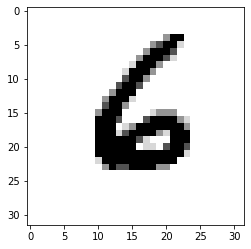

In [48]:
idx = np.random.randint(0, len(y_test))
print(idx)
print('Ture label:', y_test[idx])
pred = get_predictions(np.array([x_test[idx]]))
print('Prediction:', pred)
plt.figure()
plt.imshow(x_test[idx,:,:,0], cmap='Greys', vmin=0, vmax=1.0)

In [94]:
img = x_test[idx]
img = tf.cast(img, tf.float32)
print(img.shape)
probs = lenet5_model(tf.cast([img], tf.float32))
print(probs.shape)

with tf.GradientTape() as tape:
    tape.watch(img)
    pred = lenet5_model(tf.cast([img], tf.float32))
    if probs.shape != pred.shape:
        raise Excpetion('Shape mismatch')
    loss = loss_fn(y_true=probs, y_pred=pred)

# gradient = tape.gradient(loss, img)

# signed_grad = tf.sign(gradient)
# perturbations = create_adversarial_examples(x_test[idx], probs)
# print(pertubations.shape)
# plt.imshow(perturbations[0])

(32, 32, 1)
(1, 10)


ValueError: Shape mismatch: The shape of labels (received (10,)) should equal the shape of logits except for the last dimension (received (1, 10)).

In [ ]:
print(f'Ture: {y_test[idx]}, Prediction: {pred[idx]}')
plt.figure()
plt.imshow(x_test[index,:,:,0], cmap='Greys', vmin=0, vmax=1.0)